# PyTorch Paper Replicating
In this notebook, I'm going to be replicating the Vision Trasnformer (ViT) architechture/paper with PyTorch.

In [1]:
## 0. Get setup

import torch
import torchvision
from torch import nn
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine
from helper_functions import download_data, plot_loss_curves

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Get data
 

In [2]:
# Setup dir paths to train and test images

train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

train_dir, test_dir

('data/pizza_steak_sushi/train', 'data/pizza_steak_sushi/test')

# 2. Create Datasets and DataLoaders

In [3]:
IMG_SIZE = 224 # This comes from the table 3 of the ViT paper

manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

manual_transforms

Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

In [4]:
# Create a batch size of 32
BATCH_SIZE = 32

# Create DataLaoders

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

## 2.3 Visualize a single image

In [5]:
# Get a batch of iamges
image_batch, label_batch = next(iter(train_dataloader))

# get a single image and label from the batch
image, label = image_batch[0], label_batch[0]

# View the single image and labelshapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(2))

(-0.5, 223.5, 223.5, -0.5)

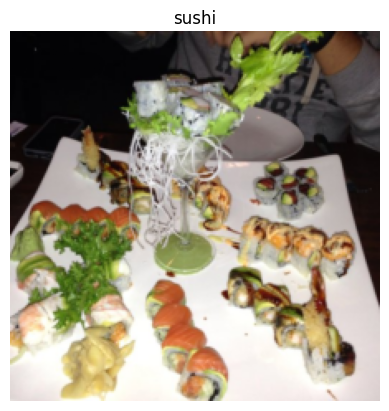

In [6]:
# Plot the image with matplotlib
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

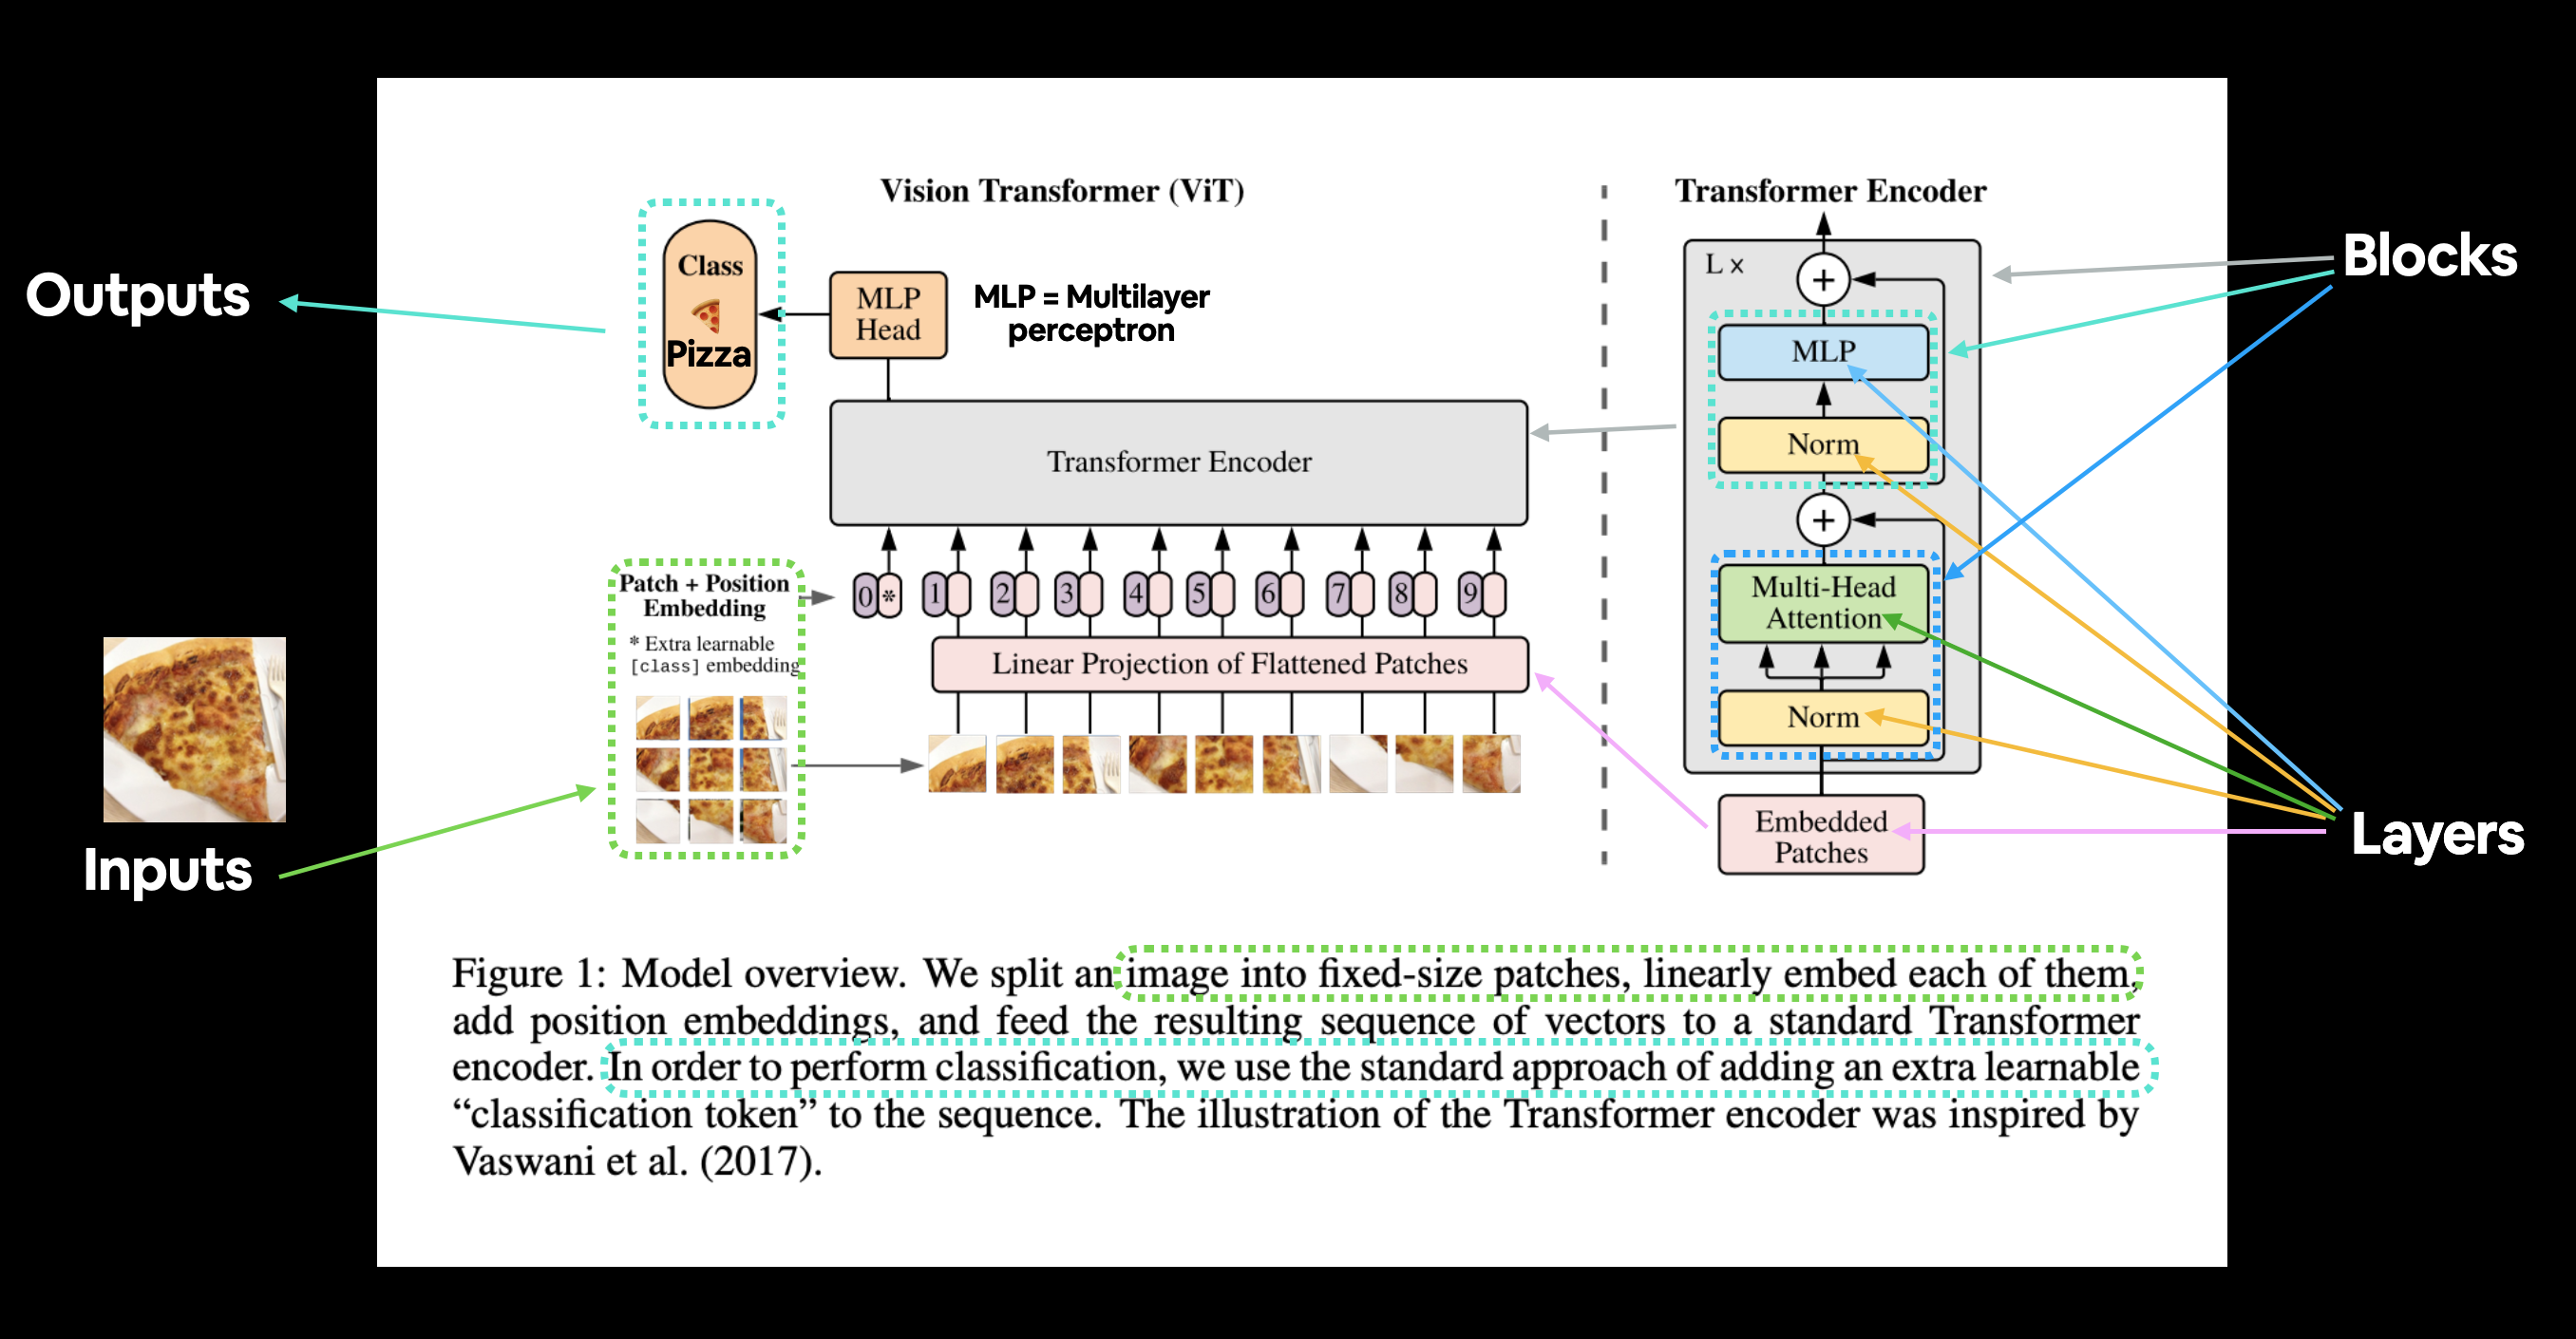

# Equations

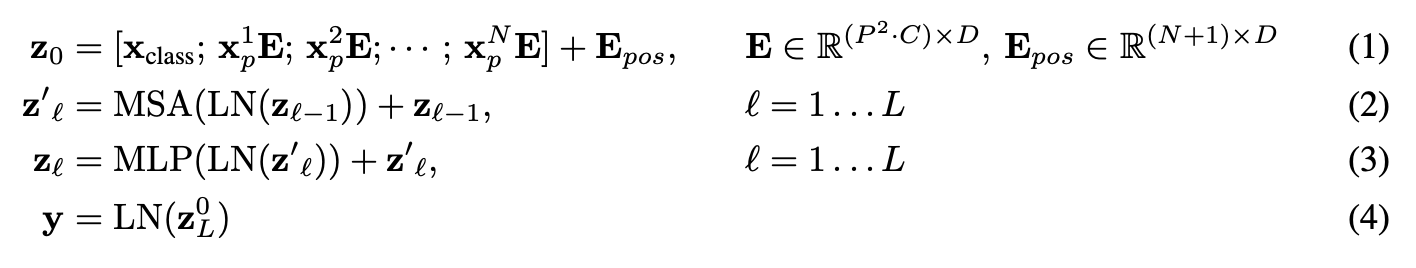

### In Pseudocode

```python
## Equation 1
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]

## Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

## Equation 3
x_output_MLP_block = MLP_layer(LN_layer(x_output_MSA_block)) + x_output_MSA_block

## Equation 4
y = Linear_layer(LN_layer(x_output_MLP_block))
```

* ViT-Base, ViT-Large, and ViT-Huge are all different sizes of the same model architecture.
* Layers - the number of transformer encoder layers
* Hidden size $D$ - the embedding size throughout the architecture
* MLP size - the number of hidden units/neurons in the MLP
* Head - the number of multi-head self-attention

# 4. Equation 1
: Split data into patches and creating the class, position and patch embedding.
### input image: Height x Width x Color channel
### output image:  Nx(P**2 * C)    // (N = (H*W)/P**2 )
 

In [7]:
# Create example values
height = 224
width = 224
color_channels = 3
patch_size = 16

# calculate the number of patches
number_of_patches = int((height * width ) / patch_size**2)
number_of_patches

196

In [8]:
# Input shape
embedding_layer_input_shape = (height, width, color_channels)

# output_shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 1D sequence of patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 1D sequence of patches): (196, 768)


## 4.2 Turning a single image into patches


torch.Size([3, 224, 224])

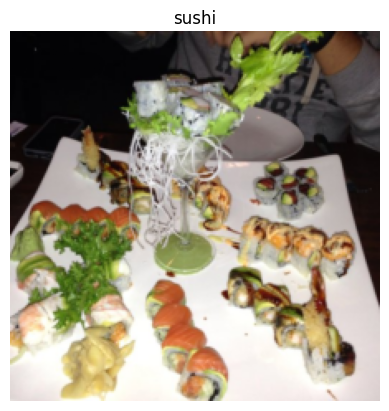

In [9]:
# View a single image
plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False);
image.shape

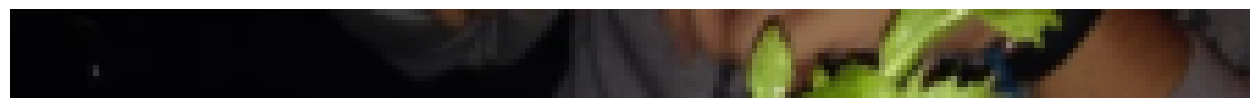

In [10]:
# Get the top of the image
image_permuted = image.permute(1, 2, 0) # Convert image to color channels (H, W, C)

# Index to plot the top row of pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size,:, :])
plt.axis(False);

Number of patches per row: 14
Patch size: 16 pixels x 16


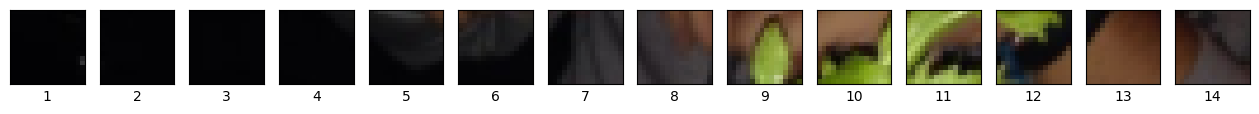

In [11]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size}")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1, # one row for each patch
                       ncols=num_patches, # one column for each patch
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))
# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]);
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [12]:
image_permuted[16:16, 16:32, :]

tensor([], size=(0, 16, 3))

Number of patches per row: 14
Patch size: 16 x 16 pixels


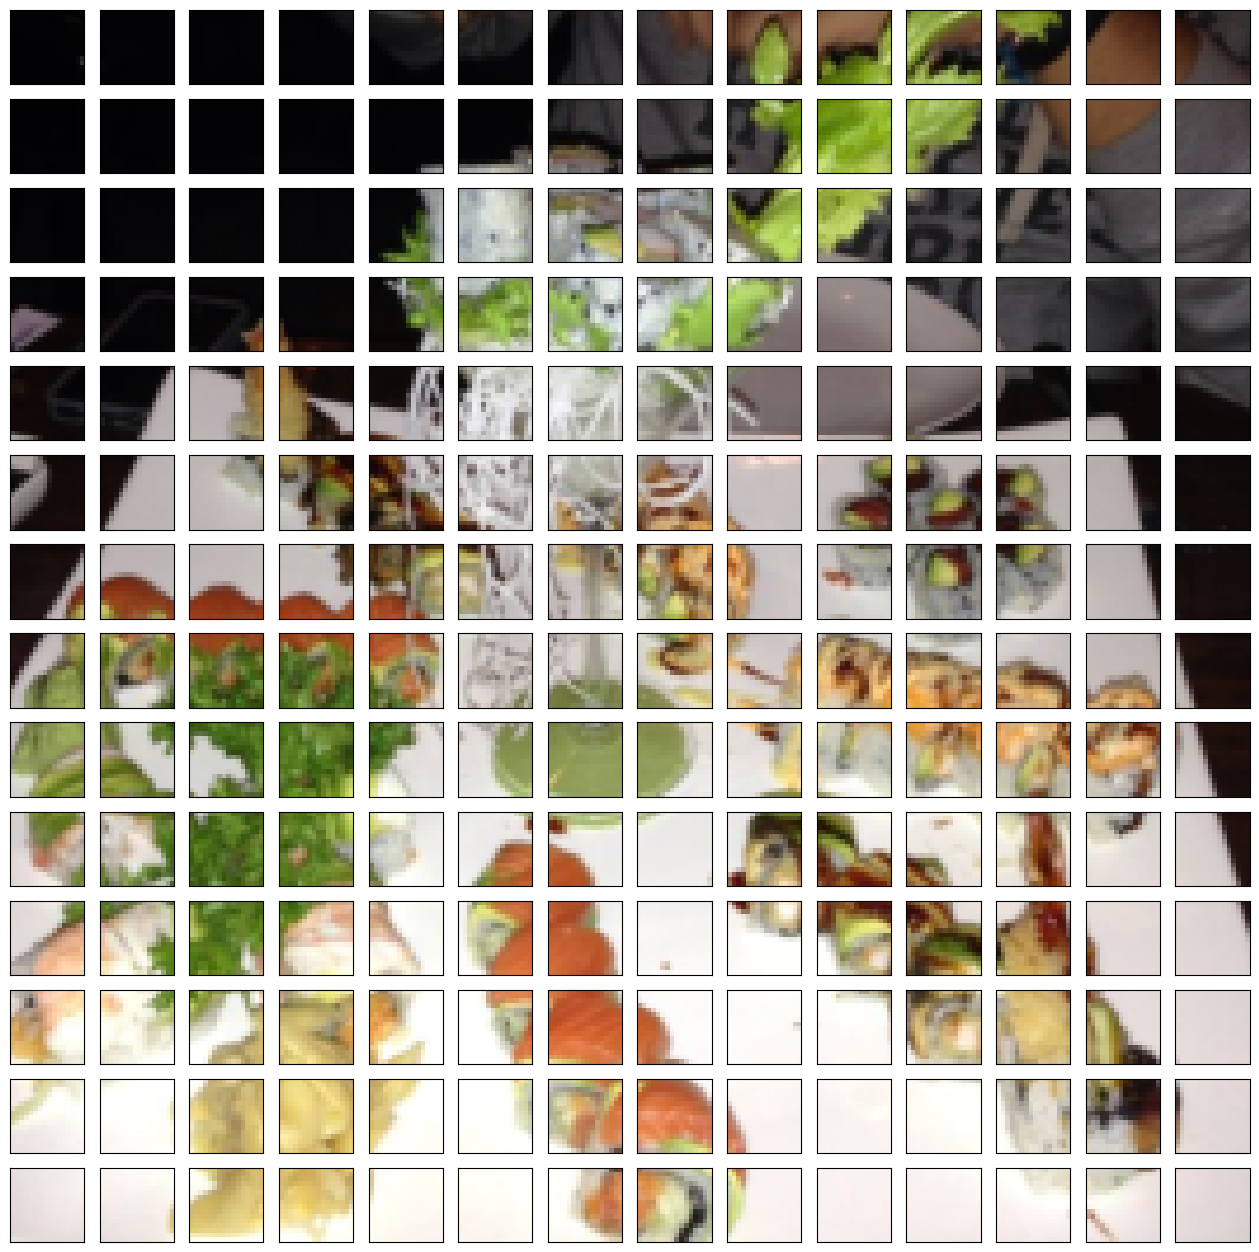

In [13]:
# Setup code to plot top row as patches

img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=num_patches, # one row for each patch
                       ncols=num_patches, # one column for each patch
                       sharex=True,
                       sharey=True,
                       figsize=(patch_size, patch_size))
# Iterate through the rows and columns
for row in range(num_patches):
    for i, patch in enumerate(range(0, img_size, patch_size)):
        axs[row, i].imshow(image_permuted[row*patch_size:(row+1)*patch_size, patch:patch+patch_size, :]);
        axs[row, i].set_xticks([])
        axs[row, i].set_yticks([])

In [14]:
len(image_permuted[:32, 32:48, :])

32

Number of patches per row: 14
Patch size: 16 pixels x 16


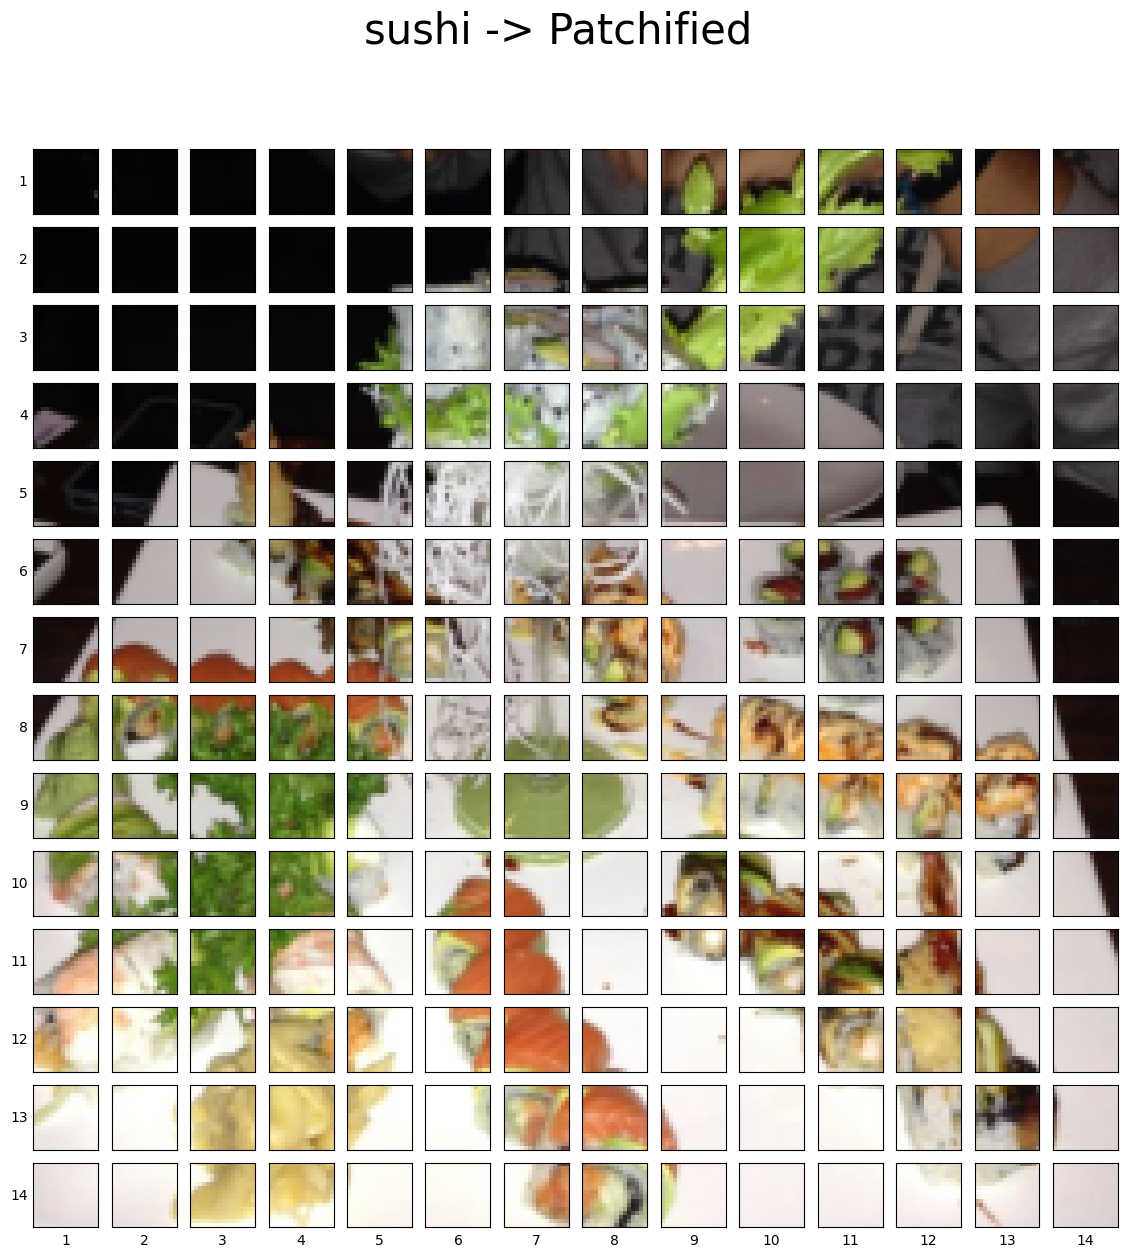

In [15]:
# Setup code to plot whole image as patches

img_size = 224
patch_size = 16
num_patches = img_size // patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size}")

fig, axs = plt.subplots(nrows=num_patches,
                        ncols=num_patches,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

listt = []
# Loop through height and wdith of image
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                        patch_width:patch_width+patch_size, # Itereate through width
                        :]) # get all color channels
        # Setup label information for each subplot (patch)
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=30)
plt.show()

 ## 4.3 Creating image patches and turning them into patch embeddings
- using `torch.nn.Conv2d()`
- setting kernel size and stride parameters to `patch_size`

In [16]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)
from torch import nn

# Set the patch size
patch_size = 16

# Create a conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3,
                  out_channels=768,
                  kernel_size=patch_size,
                  stride=patch_size,
                  padding=0)
conv2d

Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))

In [17]:
# Pass the image thorugh the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension --> (batch_size, color_channels, height, width)
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

Showing random convolutional feature maps from indexes: [543, 30, 154, 272, 619]



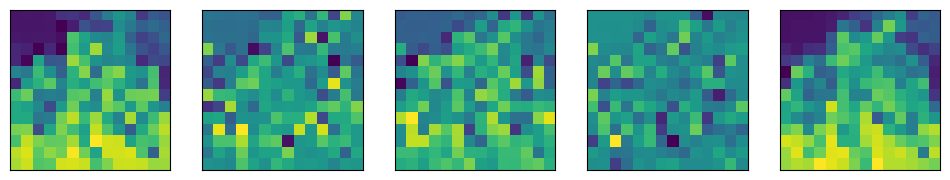

In [18]:
# plot random convolutional feature maps (embeddings)

import random
random_indexes = random.sample(range(0, 768), k=5)
print(f"Showing random convolutional feature maps from indexes: {random_indexes}\n")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # indexes on the output tensor of the conv2d layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [19]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, idx, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[0.0401, 0.0437, 0.0435, 0.0497, 0.0640, 0.0883, 0.1555, 0.1874,
           0.2904, 0.3564, 0.4209, 0.1580, 0.2731, 0.2374],
          [0.0411, 0.0459, 0.0465, 0.0495, 0.0682, 0.3328, 0.2626, 0.1294,
           0.3712, 0.6697, 0.4527, 0.2439, 0.2341, 0.2508],
          [0.0452, 0.0495, 0.0510, 0.0514, 0.2331, 0.6319, 0.4090, 0.4566,
           0.6418, 0.4480, 0.1592, 0.1278, 0.2660, 0.2497],
          [0.0882, 0.0558, 0.1141, 0.1186, 0.2541, 0.6023, 0.6254, 0.5007,
           0.4527, 0.3915, 0.4090, 0.1975, 0.1209, 0.1684],
          [0.1431, 0.1909, 0.3749, 0.3139, 0.5757, 0.6587, 0.5782, 0.4540,
           0.3592, 0.3634, 0.3141, 0.4271, 0.2535, 0.1000],
          [0.0028, 0.6511, 0.5364, 0.2591, 0.2913, 0.5098, 0.4574, 0.4760,
           0.5841, 0.4294, 0.3973, 0.3196, 0.3360, 0.0749],
          [0.1152, 0.4502, 0.3145, 0.3849, 0.2494, 0.5531, 0.4247, 0.5681,
           0.5996, 0.6127, 0.3650, 0.4944, 0.5847, 0.0853],
          [0.6371, 0.4858, 0.2692, 0.3334, 0.3341, 0.59

 ## 4.4 Flattening  the patch embedding with `torch.nn.Flatten()`

In [20]:
image_out_of_conv.shape

torch.Size([1, 768, 14, 14])

In [21]:
flatten_layer = nn.Flatten(start_dim=2,
                          end_dim=3)

flatten_layer(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image_feature map shape: torch.Size([1, 768, 196])



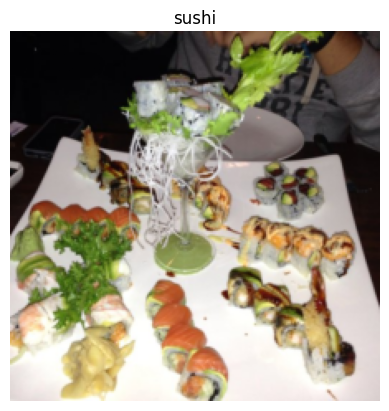

In [22]:
# Put everything together
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f"Original image shape {image.shape}")

# Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # Add batch dimension
print(f"Image feature map (patches) shape: {image_out_of_conv.shape}")

# Flatten the feature maps
image_out_of_conv_flattened = flatten_layer(image_out_of_conv)
print(f"Flattened image_feature map shape: {image_out_of_conv_flattened.shape}\n")

In [23]:
# Rearrange output of flattened layer
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)
image_out_of_conv_flattened_permuted.shape

torch.Size([1, 196, 768])

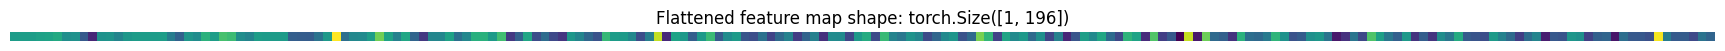

In [24]:
# Get a single flattened feature map
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

# Turning the ViT patch embedding layer into a PyTorch module

In [25]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size:int=16, embedding_dim:int=768):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
    
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                out_channels=embedding_dim,
                                kernel_size=patch_size,
                                stride=patch_size,
                                padding=0)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}" 

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)

        return x_flattened.permute(0, 2, 1)
        

In [26]:
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

print(f"Input image size: {image.unsqueeze(0).shape}")

patch_embedded_img = patchify(image.unsqueeze(0))
print(f"Patch embedding sequence shape: {patch_embedded_img.shape}")

Input image size: torch.Size([1, 3, 224, 224])
Patch embedding sequence shape: torch.Size([1, 196, 768])


## Creating the class token embedding

In [27]:
patch_embedded_img

tensor([[[ 1.7010e-03,  1.2493e-02, -9.0651e-03,  ...,  5.5775e-05,
          -1.2512e-03, -2.5820e-02],
         [ 6.6524e-04,  2.8000e-02, -2.8247e-04,  ...,  2.5622e-04,
           9.8103e-03, -3.2797e-02],
         [-2.0029e-03,  2.8714e-02,  1.6601e-03,  ...,  3.7203e-04,
           9.9795e-03, -3.2794e-02],
         ...,
         [ 2.3175e-02, -1.7707e-01,  3.4236e-01,  ..., -3.0443e-01,
           1.8054e-01, -5.2245e-01],
         [ 4.6656e-02, -2.1766e-01,  3.0632e-01,  ..., -2.1319e-01,
           1.4278e-01, -5.3015e-01],
         [ 3.2979e-02, -1.5805e-01,  3.3118e-01,  ..., -2.5436e-01,
           1.6461e-01, -4.7090e-01]]], grad_fn=<PermuteBackward0>)

In [28]:
# Get the batch size and embedding dimension

batch_size = patch_embedded_img.shape[0]
embedding_dimension = patch_embedded_img.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [29]:
            # In Practice torch.randn() is used                      
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)
class_token.shape

torch.Size([1, 1, 768])

In [30]:
# Add the class token embedding to the front of the patch embedding

patch_embedded_img_with_class_embedding = torch.cat((class_token, patch_embedded_img), dim=1) # number of patches dimension

print(patch_embedded_img_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_img_with_class_embedding.shape}/"
      f"-->(batch_size, class_token + number_of_patches, embedding_dim")

tensor([[[ 1.0000e+00,  1.0000e+00,  1.0000e+00,  ...,  1.0000e+00,
           1.0000e+00,  1.0000e+00],
         [ 1.7010e-03,  1.2493e-02, -9.0651e-03,  ...,  5.5775e-05,
          -1.2512e-03, -2.5820e-02],
         [ 6.6524e-04,  2.8000e-02, -2.8247e-04,  ...,  2.5622e-04,
           9.8103e-03, -3.2797e-02],
         ...,
         [ 2.3175e-02, -1.7707e-01,  3.4236e-01,  ..., -3.0443e-01,
           1.8054e-01, -5.2245e-01],
         [ 4.6656e-02, -2.1766e-01,  3.0632e-01,  ..., -2.1319e-01,
           1.4278e-01, -5.3015e-01],
         [ 3.2979e-02, -1.5805e-01,  3.3118e-01,  ..., -2.5436e-01,
           1.6461e-01, -4.7090e-01]]], grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768])/-->(batch_size, class_token + number_of_patches, embedding_dim


## Creating the Position Embedding

In [31]:
# calculate N (number_of_patches)
number_of_patches = int((height * width) / patch_size**2)

# Get the mebedding dimension
embedding_dimension = patch_embedded_img_with_class_embedding.shape[-1]

# Create the learnable 1D position embedding
position_embedding = nn.Parameter(torch.ones(1, 
                                            number_of_patches+1,
                                            embedding_dimension),
                                 requires_grad=True)

print(f"Number of Patches: {number_of_patches}")
position_embedding, position_embedding.shape

Number of Patches: 196


(Parameter containing:
 tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]], requires_grad=True),
 torch.Size([1, 197, 768]))

In [32]:
patch_and_position_embedding = patch_embedded_img_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"\nPatch and position embedding shape: {patch_and_position_embedding.shape}")

tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [1.0017, 1.0125, 0.9909,  ..., 1.0001, 0.9987, 0.9742],
         [1.0007, 1.0280, 0.9997,  ..., 1.0003, 1.0098, 0.9672],
         ...,
         [1.0232, 0.8229, 1.3424,  ..., 0.6956, 1.1805, 0.4775],
         [1.0467, 0.7823, 1.3063,  ..., 0.7868, 1.1428, 0.4698],
         [1.0330, 0.8420, 1.3312,  ..., 0.7456, 1.1646, 0.5291]]],
       grad_fn=<AddBackward0>)

Patch and position embedding shape: torch.Size([1, 197, 768])


## Putting it all together

In [33]:
# Set patch Size
patch_size = 16

# 2. Print shapes of the original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add a batch dimension
x = image.unsqueeze(0)
print(f"Input image shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding()

# 5. Pass input image through PatchPatchEmbedding
patch_embedding = patch_embedding_layer(x)
print(f"Patch embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                          requires_grad=True)
print(f"Class token shape: {class_token.shape}")

# 7. Prepend the class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height*width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                 requires_grad=True)
print(f"Position embedding shape: {position_embedding.shape}")

# 9. Add the position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Position embedding shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


# Equation 2: Multihead Self-Attention (MSA block)

In [34]:
class MultiHeadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block"""
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                attn_dropout:int=0):
        super().__init__()
        
        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create multihead attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                   num_heads=num_heads,
                                                   dropout=attn_dropout,
                                                   batch_first=True) # is the batch first? (batch, seq, feature) --> (batch, number of patches, embedding_dimension)
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)

        return attn_output

In [35]:
# Create an instance MSA block
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dim=768,
                                                             num_heads=12,
                                                             attn_dropout=0)

patched_img_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape of MSA block: {patched_img_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape of MSA block: torch.Size([1, 197, 768])


In [36]:
patch_and_position_embedding

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.9765,  0.9669,  0.9764,  ...,  0.9852,  1.0467,  1.0202],
         [ 0.9788,  0.9822,  0.9796,  ...,  0.9870,  1.0510,  1.0020],
         ...,
         [ 0.2409,  0.5092, -0.5781,  ...,  2.0056,  2.1770,  0.6964],
         [ 0.3174,  0.4875, -0.4906,  ...,  1.9447,  2.0827,  0.7380],
         [ 0.3035,  0.5745, -0.4363,  ...,  1.9110,  2.0625,  0.7125]]],
       grad_fn=<AddBackward0>)

In [37]:
patched_img_through_msa_block

tensor([[[ 0.2511, -0.0185,  0.6595,  ..., -0.1468,  0.1985, -0.2586],
         [ 0.2567, -0.0149,  0.6649,  ..., -0.1648,  0.1820, -0.2497],
         [ 0.2553, -0.0127,  0.6630,  ..., -0.1726,  0.1877, -0.2498],
         ...,
         [ 0.2749, -0.0089,  0.6531,  ..., -0.1549,  0.1798, -0.2556],
         [ 0.2760, -0.0098,  0.6516,  ..., -0.1560,  0.1795, -0.2557],
         [ 0.2751, -0.0090,  0.6542,  ..., -0.1549,  0.1795, -0.2569]]],
       grad_fn=<TransposeBackward0>)

# MLP | Equation 3
x = linear -> non-linear -> dropout -> linear -> dropout

In [38]:
class MLPBlock(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                mlp_size:int=3072,
                dropout:int=0.1):
        super().__init__()

        # Create the norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # Create the MLP
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)

        return x
        

In [39]:
# Createa an instance of MLPBlock class
mlp_block = MLPBlock()

# Pass output the MSABlock output through MLPBlock
patched_img_through_mlp_block = mlp_block(patched_img_through_msa_block)
print(f"Input shape of MLP block: {patched_img_through_msa_block.shape}")
print(f"Output shape of MLP block: {patched_img_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape of MLP block: torch.Size([1, 197, 768])


# Creating a PyTorch class for the transformer encoder of (ViT) paper

In [40]:
class TransformerEncoderBlock(nn.Module):
    def __init__(self,
                 embedding_dim:int=768, #hidden size D from table 1, 768 for ViT-Base
                 num_heads:int=12, # from table 1
                 mlp_size:int=3072, # from table 1
                 mlp_dropout:int=0.1, # from table 3
                 attn_dropout:int=0):
        super().__init__()

        # Create MSA block (equation 2)
        self.msa_block = MultiHeadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # Create MLP block (equation 3)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                  mlp_size=mlp_size,
                                  dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x # residual/skip connection for equation 2
        x = self.mlp_block(x) + x # residual/skip connection for equation 3
        return x

In [41]:
# Create an instance for TraTransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Get a summary using torchinfo.summary
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

C:\Users\Jamshid\Desktop\pytorch\venv\Lib\site-packages\torch\nn\modules\activation.py:1196: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  return torch._native_multi_head_attention(


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

# Create a Transformer Encoder layer with in-built PyTorch layers
`torch.nn.TransformerEncoderLayer()`

In [42]:
# Create the same as above using Torch
torch_transfomer_encoder_layer = nn.TransformerEncoderLayer(d_model=768,
                                                            nhead=12,
                                                            dim_feedforward=3072,
                                                            dropout=0.1,
                                                            activation="gelu",
                                                            batch_first=True,
                                                            norm_first=True)
torch_transfomer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [43]:
# Get a summary using torchinfo.summary
summary(model=torch_transfomer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

# Putting it all together to create ViT

In [52]:
# Create a ViT class
class ViT(nn.Module):
    def __init__(self,
                img_size:int=224, # Table 3 from the ViT paper
                in_channels:int=3,
                patch_size:int=16,
                num_transformer_layers:int=12,
                embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                mlp_size:int=3072, # Table 1
                num_heads:int=12,  # Table 1
                attn_dropout:int=0,
                mlp_dropout:int=0.1,
                embedding_dropout:int=0.1, # Dropout for patch and position embeddings
                num_classes:int=1000): # Num of classes in our classification problem
        super().__init__()
        # Make an assertion that the image size is compatible with the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by the patch size, image size: {img_size}, patch_size: {patch_size}."
    
        # Calculate the number of patches (height *width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2
    
        # Create a learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                           requires_grad=True)
    
        # Create a learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim))
    
        # Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
    
        # Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                             patch_size=patch_size,
                                             embedding_dim=embedding_dim)
        
        # Create the Transformer Encoder block
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                          num_heads=num_heads,
                                                                          mlp_size=mlp_size,
                                                                          mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
    
        # Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                     out_features=num_classes)
        )
    def forward(self, x):
        # get the batch size
        batch_size = x.shape[0]

        # Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimensions

        # Create the patch embedding (equation 1)
        x = self.patch_embedding(x)

        # Concat class token embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1) # (batch_size, number_of_patches, embedding_dim)

        # Add position embedding to class token and patch embedding
        x = self.position_embedding + x

        # Apply dropout to patch embedding ("directly after positional= to patch embeddings")
        x = self.embedding_dropout(x)

        # Pass position and patch embedding to Transformer Encoder (equation 2 and 3)
        x = self.transformer_encoder(x)

        # Put 0th index logit through classifier (equation 4)
        x = self.classifier(x[:, 0])
        
        return x

In [53]:
batch_size = 32
embedding_dim = 768
class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                              requires_grad=True)
class_embedding_expanded = class_embedding.expand(batch_size, -1, -1)
print(class_embedding.shape)
print(class_embedding_expanded.shape)

torch.Size([1, 1, 768])
torch.Size([32, 1, 768])


In [54]:
vit = ViT()
vit

ViT(
  (embedding_dropout): Dropout(p=0.1, inplace=False)
  (patch_embedding): PatchEmbedding(
    (patcher): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten): Flatten(start_dim=2, end_dim=3)
  )
  (transformer_encoder): Sequential(
    (0): TransformerEncoderBlock(
      (msa_block): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
  

In [61]:
# Create a random image tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, and sushi)
vit = ViT(num_classes=3)

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

tensor([[ 0.5438, -0.6564, -1.0148]], grad_fn=<AddmmBackward0>)

In [64]:
from torchinfo import summary

summary(model=ViT(num_classes=3),
       input_size=(1,3,224,224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbedding (patch_embedding)                           [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patcher)                                      [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten)                                     [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (embedding_dropout)                                [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (transformer_encoder)                           [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransformerEncoderBlock (0)                           [1, 197, 768]        [1, 197, 768] 

# Setting up training code for our custom ViT

In [71]:
# Setup loss function and optimizers
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=vit.parameters(),
                          lr=1e-3, # 0.001
                          betas=(0.9, 0.999),
                          weight_decay=0.1)

In [73]:
from going_modular import engine

model = vit.to(device)

results = engine.train(
    model = model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    epochs=10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device=device
)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [10:10<00:00, 61.00s/it]


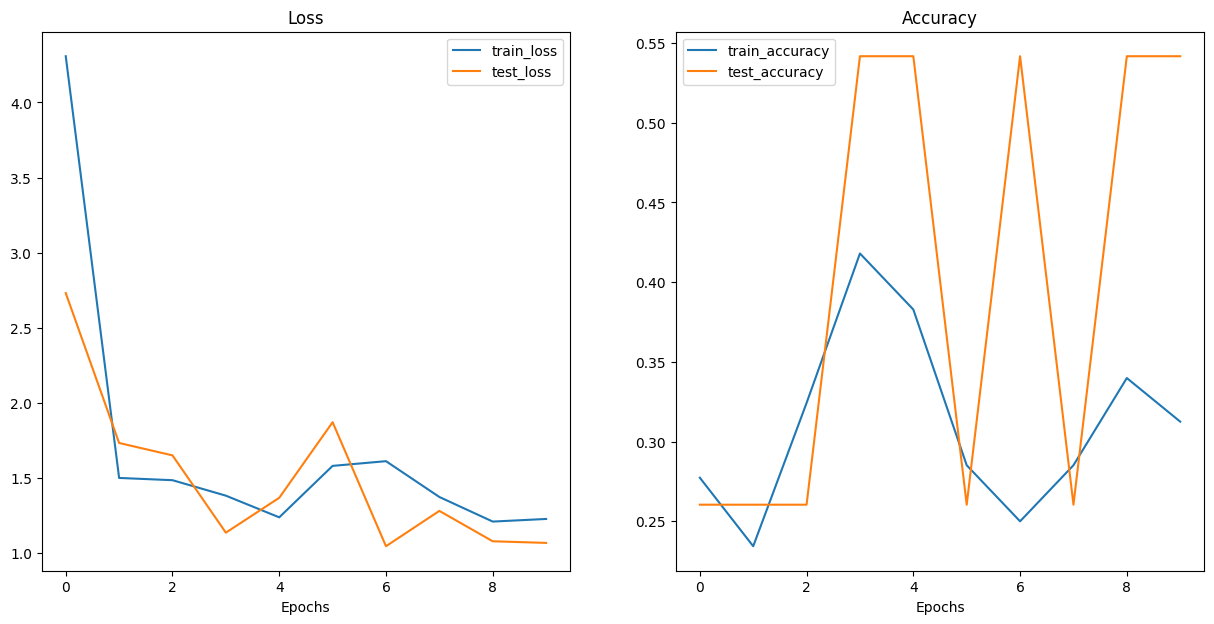

In [74]:
from helper_functions import plot_loss_curves

plot_loss_curves(results)

# Using a pre-trained ViT from `torchvision.models`

In [75]:
device

'cuda'

In [79]:
# Get pre-trained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT # "DEFAULT" = best available

# Setup a ViT model instance with pre-trained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# Update the classifier head
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

In [80]:
from torchinfo import summary

summary(model=pretrained_vit,
       input_size=(1,3,224,224),
       col_names=["input_size", "output_size", "num_params", "trainable"],
       col_width=20,
       row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [81]:
## Preparing the data for the pretrained ViT model
vit_transforms = pretrained_vit_weights.transforms()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [83]:
# Setup datalaoders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                    test_dir=test_dir,
                                                                                                    transform=vit_transforms,
                                                                                                    batch_size=32)

In [104]:
train_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [94]:
test_dataloader_pretrained.dataset

Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BILINEAR
           )

In [113]:
## Train feauture extractor ViT Model

# Setup loss function and optimizers
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=pretrained_vit.parameters(), lr=0.001)

pretrained_vit_results = engine.train(model=pretrained_vit,
                                     train_dataloader=train_dataloader_pretrained,
                                     test_dataloader=test_dataloader_pretrained,
                                     optimizer=optimizer,
                                     loss_fn=loss_fn,
                                     epochs=10,
                                     device=device)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:38<00:00, 33.86s/it]


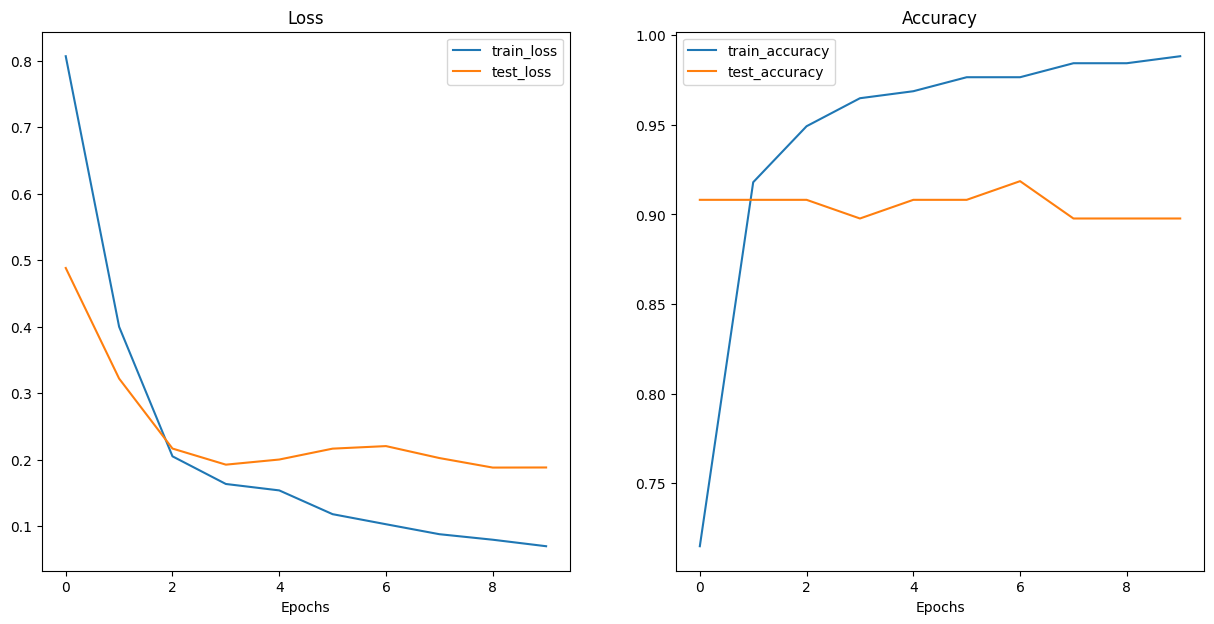

In [114]:
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [117]:
pretrained_vit_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [118]:
max(pretrained_vit_results['train_acc']), max(pretrained_vit_results['test_acc'])

(0.98828125, 0.9185606060606061)

# Saving our best performing ViT model

In [119]:
# Save the model

from going_modular import utils

utils.save_model(model=pretrained_vit,
                target_dir='models',
                model_name='pretrained_vit_feature_extractor_1.pth')

[INFO] Saved model to: models\pretrained_vit_feature_extractor_1.pth


In [120]:
# See the model size
from pathlib import Path
pretrained_vit_model_size = Path('models/pretrained_vit_feature_extractor_1.pth').stat().st_size // (1024*1024) #Division converts bytes to megebytes (roughly)
print(f"Pre-trained ViT feature extractor model size: {pretrained_vit_model_size} MB.")


Pre-trained ViT feature extractor model size: 327 MB.


# Making predictions on a custom image

In [123]:
# Download the image
import requests

data_path = Path("data/")

# Setup custom image path
custom_image_path = data_path / "pizza_grandpa_img.jpg"

# Download the image if it doesn't exist
if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        # Download any image from the internet
        request = requests.get("https://brooklynreporter.com/wp-content/uploads/2022/03/pic-15-976x1024.jpg")
        print(f"Download {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download")

data\pizza_grandpa_img.jpg already exists, skipping download


In [141]:
custom_image_path

WindowsPath('data/pizza_grandpa_img.jpg')

Transformed image shape: torch.Size([1, 3, 224, 224])


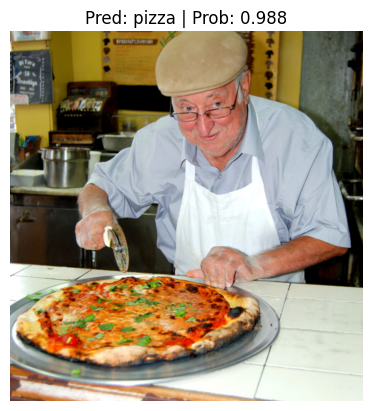

In [152]:
# from helper_functions import pred_and_plot_image

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                   image_path=custom_image_path,
                   class_names=class_names)